In [120]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Challenge

Our objective is to determine whether the user is intoxicated. If the user is found to be drunk, the application will suggest a lighter beer, creating an automatic bias towards it. Conversely, if the user is sober, the application will not exhibit this bias, increasing the likelihood of the user selecting a higher ABV beer. To achieve accurate results, we require two datasets: one comprising data from intoxicated individuals and the other from sober individuals. Ensuring the absence of bias in these datasets is crucial for maintaining high accuracy.

## Sober images

```python
def create_dir_structure(base_dir, categories, split_names):
    for category in categories:
        for split in split_names:
            os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

def split_data(src_dir, categories, base_dir, test_size=0.2, val_size=0.1):
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    val_dir = os.path.join(base_dir, 'val')
    
    create_dir_structure(base_dir, categories, ['train', 'test', 'val'])
    
    for category in categories:
        category_path = os.path.join(src_dir, category)
        images = os.listdir(category_path)
        
        train_and_val, val = train_test_split(images, test_size=test_size, random_state=42)
        train, test = train_test_split(train_and_val, test_size=val_size/(1-test_size), random_state=42)
        
        for split, split_dir in zip([train, test, val], [train_dir, test_dir, val_dir]):
            for image in split:
                src_image_path = os.path.join(category_path, image)
                dest_image_path = os.path.join(split_dir, category, image)
                shutil.copy(src_image_path, dest_image_path)
                
src_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\Male and Female face dataset'  # e.g., 'dataset'
categories = ['men', 'women']
base_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\Male and Female face dataset'  # e.g., 'split_dataset'

split_data(src_dir, categories, base_dir)
```

In [2]:
#def create_dir_structure(base_dir, categories, split_names):
#    for category in categories:
#        for split in split_names:
#            os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)
#
#def split_data(src_dir, categories, base_dir, test_size=0.2, val_size=0.1):
#    train_dir = os.path.join(base_dir, 'train')
#    test_dir = os.path.join(base_dir, 'test')
#    val_dir = os.path.join(base_dir, 'val')
#    
#    create_dir_structure(base_dir, categories, ['train', 'test', 'val'])
#    
#    for category in categories:
#        category_path = os.path.join(src_dir, category)
#        images = os.listdir(category_path)
#        
#        train_and_val, val = train_test_split(images, test_size=test_size, random_state=42)
#        train, test = train_test_split(train_and_val, test_size=val_size/(1-test_size), random_state=42)
#        
#        for split, split_dir in zip([train, test, val], [train_dir, test_dir, val_dir]):
#            for image in split:
#                src_image_path = os.path.join(category_path, image)
#                dest_image_path = os.path.join(split_dir, category, image)
#                shutil.copy(src_image_path, dest_image_path)
#                
#src_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\Male and Female face dataset'  # e.g., 'dataset'
#categories = ['men', 'women']
#base_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\Male and Female face dataset'  # e.g., 'split_dataset'
#
#split_data(src_dir, categories, base_dir)

In [3]:
datagen = ImageDataGenerator(rescale=1.0/255.0,
                             preprocessing_function=preprocess_input)

In [4]:
BATCHSIZE = 64

In [5]:
print('train dataset:')
train_generator_sober = datagen.flow_from_directory(
    "Data/Male and Female face dataset/train",
    batch_size=BATCHSIZE,
    seed=10,
    class_mode="binary",
    shuffle=True)

print('\ntest dataset:')
test_generator_sober = datagen.flow_from_directory(
    "Data/Male and Female face dataset/test",
    batch_size=BATCHSIZE,
    seed=10,
    class_mode="binary",
    shuffle=False)

print('\nvalidation dataset:')
validation_generator_sober = datagen.flow_from_directory(
    "Data/Male and Female face dataset/val",
    batch_size=BATCHSIZE,
    seed=10,
    class_mode="binary")

train dataset:
Found 0 images belonging to 2 classes.

test dataset:
Found 0 images belonging to 2 classes.

validation dataset:
Found 0 images belonging to 2 classes.


Text(0, 0.5, 'Amount')

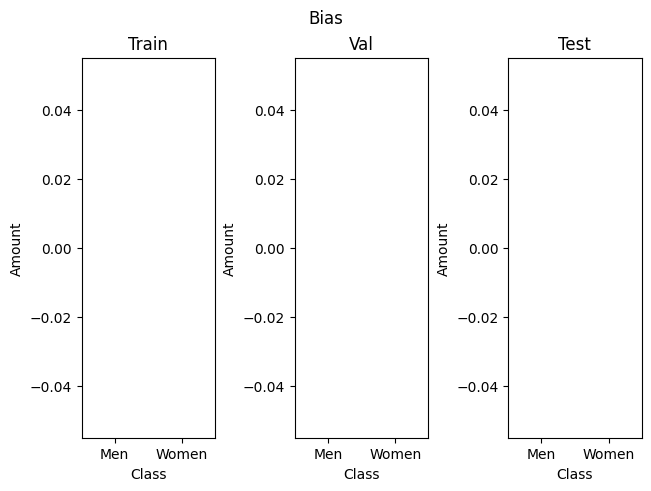

In [6]:
# Bias check Plot
fig, axs = plt.subplots(1,3, layout='constrained')
plt.suptitle('Bias')

axs[0].bar(
    'Men',
    np.sum(train_generator_sober.labels == 0)
)
axs[0].bar(
    'Women',
    np.sum(train_generator_sober.labels == 1)
)
axs[0].set_title('Train')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Amount')

axs[1].bar(
    'Men',
    np.sum(validation_generator_sober.labels == 0)
)
axs[1].bar(
    'Women',
    np.sum(validation_generator_sober.labels == 1)
)
axs[1].set_title('Val')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Amount')


axs[2].bar(
    'Men',
    np.sum(test_generator_sober.labels == 0)
)
axs[2].bar(
    'Women',
    np.sum(test_generator_sober.labels == 1)
)
axs[2].set_title('Test')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Amount')

## Drunk dataset

```python
def create_dir_structure(base_dir, categories, split_names):
    for category in categories:
        for split in split_names:
            os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

def split_data(src_dir, categories, base_dir, test_size=0.2, val_size=0.1):
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    val_dir = os.path.join(base_dir, 'val')
    
    create_dir_structure(base_dir, categories, ['train', 'test', 'val'])

    for category in categories:
        category_path = os.path.join(src_dir, category)
        images = os.listdir(category_path)
        
        train_and_val, val = train_test_split(images, test_size=test_size, random_state=42)
        train, test = train_test_split(train_and_val, test_size=val_size/(1-test_size), random_state=42)
        
        for split, split_dir in zip([train, test, val], [train_dir, test_dir, val_dir]):
            for image in split:
                src_image_path = os.path.join(category_path, image)
                dest_image_path = os.path.join(split_dir, category, image)
                shutil.copy(src_image_path, dest_image_path)

src_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\imagesDrunk'  # e.g., 'dataset'
categories = ['drunk']
base_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\imagesDrunk'  # e.g., 'split_dataset'

split_data(src_dir, categories, base_dir)

In [7]:
#def create_dir_structure(base_dir, categories, split_names):
#    for category in categories:
#        for split in split_names:
#            os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)
#
#def split_data(src_dir, categories, base_dir, test_size=0.2, val_size=0.1):
#    train_dir = os.path.join(base_dir, 'train')
#    test_dir = os.path.join(base_dir, 'test')
#    val_dir = os.path.join(base_dir, 'val')
#    
#    create_dir_structure(base_dir, categories, ['train', 'test', 'val'])
#
#    for category in categories:
#        category_path = os.path.join(src_dir, category)
#        images = os.listdir(category_path)
#        
#        train_and_val, val = train_test_split(images, test_size=test_size, random_state=42)
#        train, test = train_test_split(train_and_val, test_size=val_size/(1-test_size), random_state=42)
#        
#        for split, split_dir in zip([train, test, val], [train_dir, test_dir, val_dir]):
#            for image in split:
#                src_image_path = os.path.join(category_path, image)
#                dest_image_path = os.path.join(split_dir, category, image)
#                shutil.copy(src_image_path, dest_image_path)
#
#src_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\imagesDrunk'  # e.g., 'dataset'
#categories = ['drunk']
#base_dir = 'D:\Documenten\Fontys\Software\Semester 6\Drunk face detection\Data\imagesDrunk'  # e.g., 'split_dataset'
#
#split_data(src_dir, categories, base_dir)

In [8]:
print('train dataset:')
train_generator_drunk = datagen.flow_from_directory(
    "Data/imagesDrunk/train",
    batch_size=BATCHSIZE,
    seed=10,
    class_mode="binary",
    shuffle=False)

print('\ntest dataset:')
test_generator_drunk = datagen.flow_from_directory(
    "Data/imagesDrunk/test",
    batch_size=BATCHSIZE,
    seed=10,
    class_mode="binary",
    shuffle=False)

print('\nvalidation dataset:')
validation_generator_drunk = datagen.flow_from_directory(
    "Data/imagesDrunk/val",
    batch_size=BATCHSIZE,
    seed=10,
    class_mode="binary",
    shuffle=False)

train dataset:
Found 3454 images belonging to 2 classes.

test dataset:
Found 495 images belonging to 2 classes.

validation dataset:
Found 988 images belonging to 2 classes.


Text(0, 0.5, 'Amount')

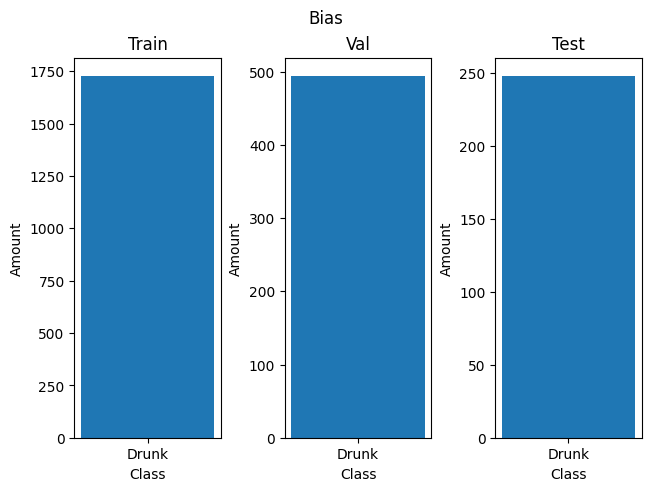

In [9]:
# Bias check Plot
fig, axs = plt.subplots(1,3, layout='constrained')
plt.suptitle('Bias')

axs[0].bar(
    'Drunk',
    np.sum(train_generator_drunk.labels == 1)
)
axs[0].set_title('Train')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Amount')

axs[1].bar(
    'Drunk',
    np.sum(validation_generator_drunk.labels == 1)
)
axs[1].set_title('Val')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Amount')


axs[2].bar(
    'Drunk',
    np.sum(test_generator_drunk.labels == 1)
)
axs[2].set_title('Test')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Amount')

## Merging datasets

Upon examining the bar plots, it is evident that the dataset for drunk individuals has the least amount of data available. To address this, I propose augmenting the drunk dataset with an equal number of sober faces for each subset. It is essential to ensure that the added data includes an equal number of male and female faces to maintain balance and accuracy in the dataset.

In [10]:
#def copy_images(src_folder, dest_folder, num_images):
#    """
#    Copies a specified number of images from the source folder to the destination folder.
#    """
#    # Get list of all files in the source folder
#    all_files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
#    
#    # Randomly select the specified number of files
#    selected_files = random.sample(all_files, num_images)
#    
#    # Copy the selected files to the destination folder
#    for file_name in selected_files:
#        shutil.copy(os.path.join(src_folder, file_name), os.path.join(dest_folder, file_name))
#
#base_dir = f'Data/Male and Female face dataset'  # Replace with the path to your image folder
#new_base_dir = 'Data/imagesDrunk'  # Replace with the path to your new image folder
#
## Subfolders in the base directory
#subfolders = ['train', 'test', 'val']
#categories = ['men', 'women']
#
## Loop through each subfolder and category
#for subfolder in subfolders:
#    if subfolder == 'train':
#        num_images = round(np.sum(train_generator_drunk.labels == 0) / 2)
#    elif subfolder == 'val':
#        num_images = round(np.sum(validation_generator_drunk.labels == 0) / 2)
#    elif subfolder == 'test':
#        num_images = round(np.sum(test_generator_drunk.labels == 0) / 2)
#    else:
#        raise ValueError("Invalid subset provided.")
#    
#    dest_folder = os.path.join(new_base_dir, subfolder, 'sober')
#    # Ensure the destination folder exists
#    os.makedirs(dest_folder)
#
#    for category in categories:
#        src_folder = os.path.join(base_dir, subfolder, category)
#        # Calculate the number of images based on your condition
#        copy_images(src_folder=src_folder, 
#                    dest_folder=dest_folder, 
#                    num_images=num_images)

In [11]:
# Create generators
train_generator = datagen.flow_from_directory('Data/imagesDrunk/train', 
                                              class_mode='binary',
                                              seed=10,
                                              shuffle=True,
                                              batch_size = BATCHSIZE,
                                              target_size = (256, 256))

validation_generator = datagen.flow_from_directory('Data/imagesDrunk/val', 
                                                   class_mode='binary',
                                                   seed=10,
                                                   batch_size = BATCHSIZE,
                                                   target_size = (256, 256))

test_generator = datagen.flow_from_directory('Data/imagesDrunk/test', 
                                             class_mode='binary',
                                             seed=10,
                                             shuffle=False,
                                             batch_size = BATCHSIZE,
                                             target_size = (256, 256))

Found 3454 images belonging to 2 classes.
Found 988 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


Train labels sober: 1727
Train labels drunk: 1727
Val labels sober: 494
Val labels drunk: 494
Test labels sober: 247
Test labels drunk: 248


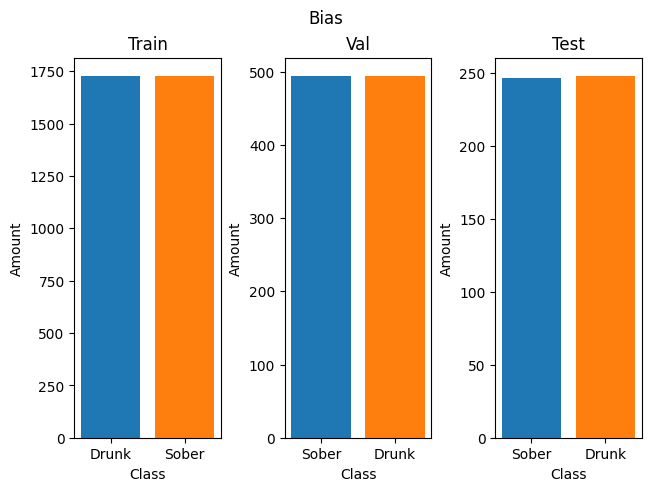

In [12]:
# Bias check Plot
fig, axs = plt.subplots(1,3, layout='constrained')
plt.suptitle('Bias')

axs[0].bar(
    'Drunk',
    np.sum(train_generator.labels == 0)
)
axs[0].bar(
    'Sober',
    np.sum(train_generator.labels == 1)
)
axs[0].set_title('Train')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Amount')

axs[1].bar(
    'Sober',
    np.sum(validation_generator.labels == 0)
)
axs[1].bar(
    'Drunk',
    np.sum(validation_generator.labels == 1)
)
axs[1].set_title('Val')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Amount')


axs[2].bar(
    'Sober',
    np.sum(test_generator.labels == 0)
)
axs[2].bar(
    'Drunk',
    np.sum(test_generator.labels == 1)
)
axs[2].set_title('Test')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Amount')

print('Train labels sober:', np.sum(train_generator.labels == 0))
print('Train labels drunk:', np.sum(train_generator.labels == 1))

print('Val labels sober:', np.sum(validation_generator.labels == 0))
print('Val labels drunk:', np.sum(validation_generator.labels == 1))

print('Test labels sober:', np.sum(test_generator.labels == 0))
print('Test labels drunk:', np.sum(test_generator.labels == 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48501962..0.59239614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48501962..0.5420432].


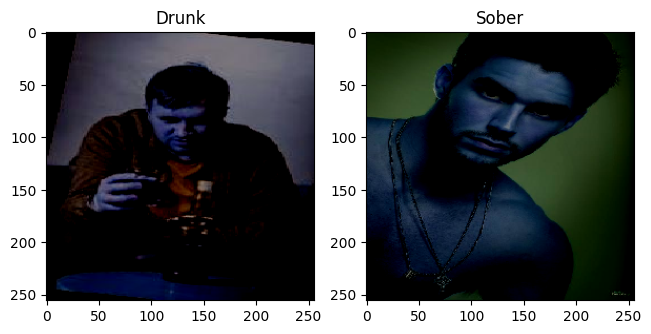

In [13]:
imgs = [1, 32]
ncols = 0

fig, axs = plt.subplots(nrows=1, ncols=2, layout='constrained')

for img in imgs:
    axs[ncols].imshow(train_generator[img][0][0])

    if train_generator[img][1][0] == 0:
        axs[ncols].set_title('Drunk')
    else:
        axs[ncols].set_title('Sober')
    ncols += 1

## Model

In [14]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [15]:
# Load the VGG16 model with pretrained weights and without the top fully connected layers
base_model = VGG16(include_top=False, 
                   input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

In [16]:
# Create a new input layer
inputs = Input(shape=(256, 256, 3))

# Pass the inputs through the base model
x = base_model(inputs, training=False)

# Add custom layers on top of the base model
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

In [17]:
# Create the new model
model = Model(inputs, outputs)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 6, 6, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 1, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,914,465 (56.89 MB)

 Trainable params: 199,777 (780.38 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [19]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta = 0.0005,
                               patience=2)

In [20]:
history = model.fit(train_generator,
                    epochs=3,
                    validation_data=validation_generator,
                    batch_size=BATCHSIZE,
                    callbacks=[early_stopping])

Epoch 1/3


c:\Users\tijnd\anaconda3\envs\Brewgle\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/54 ━━━━━━━━━━━━━━━━━━━━ 1:35 6s/step - accuracy: 0.7242 - loss: 0.5162

c:\Users\tijnd\anaconda3\envs\Brewgle\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 402s 7s/step - accuracy: 0.7646 - loss: 0.4584 - val_accuracy: 0.9383 - val_loss: 0.1699
Epoch 2/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 409s 8s/step - accuracy: 0.9532 - loss: 0.1310 - val_accuracy: 0.9615 - val_loss: 0.0949
Epoch 3/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 400s 7s/step - accuracy: 0.9691 - loss: 0.0751 - val_accuracy: 0.9696 - val_loss: 0.0897


In [21]:
# Model Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f'Model:\n   Test Loss: {test_loss}, Test Accuracy: {test_acc}\n')

8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9631 - loss: 0.0987
Model:
   Test Loss: 0.15104475617408752, Test Accuracy: 0.9535353779792786



## Visuals

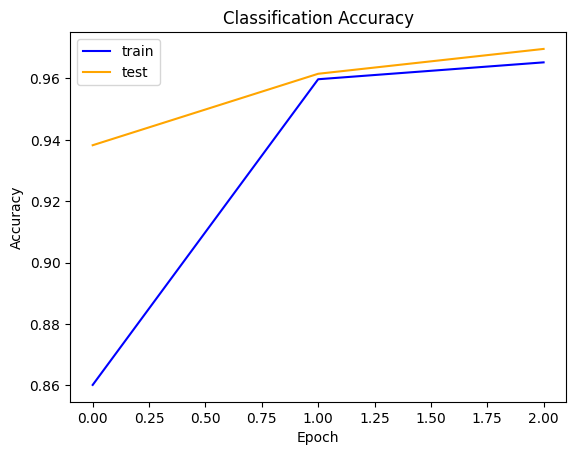

In [22]:
# plot accuracy
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [23]:
predictions = model.predict(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step


predicted_classes: 495
true_classes: 495
predicted_classes: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]


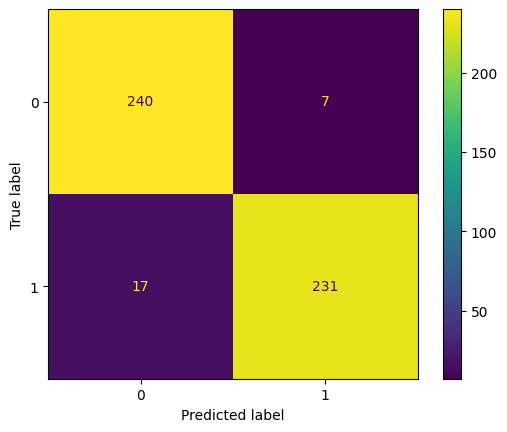

In [24]:
true_classes = test_generator.classes
predicted_classes = (predictions >= 0.6).astype(int)

print('predicted_classes:', len(predicted_classes))
print('true_classes:', len(true_classes))
print('predicted_classes:', predicted_classes)
print('true_classes:', true_classes)

# Create the confusion matrix
confusionMatrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)

# Display the confusion matrix
confusionMatrixDisp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)
confusionMatrixDisp.plot()

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9705882352941176
Recall: 0.9314516129032258
F1 Score: 0.9506172839506173


In [26]:
indexes = []
for i in range(len(true_classes)):
    if predicted_classes[i] == true_classes[i] and true_classes[i] == 1:
        indexes.append(i)

In [27]:
name = 'modelv0.12'

if not os.path.exists(os.path.join('Trained_models/h5/', f'{name}.h5')):
    model.save(f'Trained_models/h5/{name}.h5')
    print('Model saved as .h5 file')
else:
    warnings.warn(f'Model with name: {name}.h5, already exists. Skipped saving model')

if not os.path.exists(os.path.join('Trained_models/keras', f'{name}.keras')):
    model.save(f'Trained_models/keras/{name}.keras')
    print('Model saved as .keras file')
else:
    warnings.warn(f'Model with name: {name}.keras, already exists. Skipped saving model')

Model saved as .h5 file
Model saved as .keras file


## Usage

In [28]:
#model = load_model('Trained_models\h5\modelv0.11.h5')

In [161]:
#Own images/Sober/WIN_20240620_09_45_25_Pro.jpg

image_path = r'Own images/Sober/WIN_20240613_09_33_58_Pro.jpg'
target_size = (256, 256)

image = load_img(path=image_path, 
                 target_size=target_size)

image_arr = img_to_array(image)
image_arr = image_arr/255.0
image_arr = np.expand_dims(image_arr, axis=0)

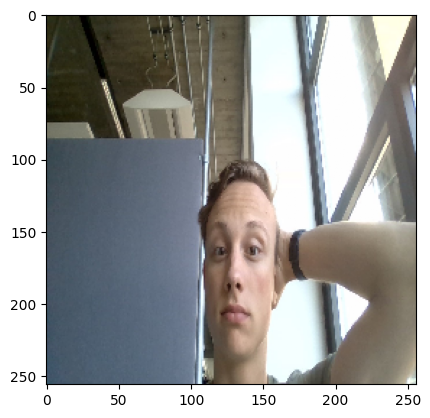

In [162]:
plt.imshow(image_arr[0])
plt.show()

In [163]:
prediction = model.predict(image_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


In [164]:
prediction

array([[0.00068683]], dtype=float32)

In [165]:
if (prediction >= 0.6).astype(int) == 0:
    print('Drunk')
else:
    print('Sober')

Drunk


Image array shape: (1, 256, 256, 3)
Generated heatmap shape: ()
Error: Invalid heatmap shape: ()


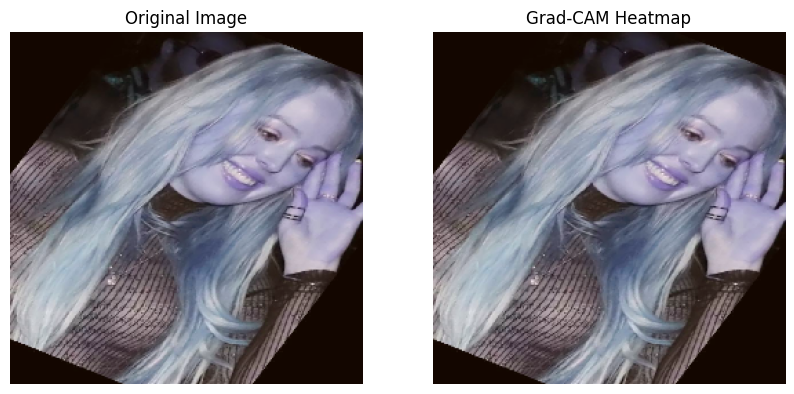

In [216]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    if grads is None:
        raise ValueError("Gradients are None, indicating an issue with the gradient calculation.")
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    if tf.reduce_max(heatmap) == 0:
        raise ValueError("Max value of heatmap is 0, indicating an issue with the heatmap generation.")
    
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def get_gradcam_image(image, heatmap, alpha=0.9):
    img = img_to_array(image)
    
    if heatmap.ndim != 2:
        heatmap = np.squeeze(heatmap)
    if heatmap.ndim != 2:
        raise ValueError(f"Invalid heatmap shape: {heatmap.shape}")
    
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() != 0:
        heatmap = heatmap / heatmap.max()

    plt.imshow(heatmap, cmap='jet')
    plt.title('Heatmap')
    plt.axis('off')
    plt.show()
    
    jet = plt.get_cmap("jet")
    jet_heatmap = jet(heatmap)
    jet_heatmap = np.uint8(jet_heatmap * 255)
    
    if jet_heatmap.shape[-1] == 4:
        jet_heatmap = jet_heatmap[..., :3]
    
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    
    if jet_heatmap.ndim == 2:
        jet_heatmap = np.stack([jet_heatmap] * 3, axis=-1)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    return array_to_img(superimposed_img)

# Generate the heatmap
img_array = get_img_array(test_generator[0][0][0])
print(f"Image array shape: {img_array.shape}")

try:
    heatmap = make_gradcam_heatmap(img_array=img_array, model=model, last_conv_layer_name='conv2d_1')
    print(f"Generated heatmap shape: {heatmap.shape}")
except ValueError as e:
    print(f"Error: {e}")

# Load the original image
image = array_to_img(test_generator[0][0][0])

# Generate the Grad-CAM image
try:
    image_gradCam = get_gradcam_image(image=image, heatmap=heatmap)
except ValueError as e:
    print(f"Error: {e}")

# Display the original image and Grad-CAM heatmap
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_gradCam)
plt.title('Grad-CAM Heatmap')
plt.axis('off')

plt.show()


In [207]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the class score with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients across the feature map dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weigh the output feature map with the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [209]:

def get_gradcam_image(image, heatmap, alpha=0.4):
    img = img_to_array(image)
    
    # Ensure heatmap has the correct shape
    print(f"Original heatmap shape: {heatmap.shape}")
    if heatmap.ndim != 2:
        heatmap = np.squeeze(heatmap)
    print(f"Squeezed heatmap shape: {heatmap.shape}")
    if heatmap.ndim != 2:
        raise ValueError(f"Invalid heatmap shape: {heatmap.shape}")
    
    # Normalize the heatmap to range 0-1
    heatmap = np.maximum(heatmap, 0)  # Ensure no negative values
    if heatmap.max() != 0:  # Prevent division by zero
        heatmap = heatmap / heatmap.max()  # Normalize to [0, 1]
    
    # Display heatmap directly for debugging
    plt.imshow(heatmap, cmap='jet')
    plt.title('Heatmap')
    plt.axis('off')
    plt.show()
    
    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")
    
    # Apply the colormap
    jet_heatmap = jet(heatmap)
    jet_heatmap = np.uint8(jet_heatmap * 255)  # Rescale to 0-255
    
    # Remove the alpha channel if present
    if jet_heatmap.shape[-1] == 4:
        jet_heatmap = jet_heatmap[..., :3]
    
    # Resize jet_heatmap to match original image size
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    
    # Ensure jet_heatmap has 3 channels (height, width, 3)
    if jet_heatmap.ndim == 2:
        jet_heatmap = np.stack([jet_heatmap] * 3, axis=-1)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    
    # Convert to image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    return array_to_img(superimposed_img)

In [210]:
def get_img_array(img):
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Add an extra dimension to the array to represent batch size (in this case, 1)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Return the NumPy array
    return img_array

In [211]:
test_generator[0][0][0].shape

(256, 256, 3)

In [212]:
# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array=get_img_array(test_generator[0][0][0]),
                               model=model, 
                               last_conv_layer_name='conv2d_1')

# Load the original image
image = array_to_img(test_generator[0][0][0])

# Generate the Grad-CAM image
image_gradCam = get_gradcam_image(image=image, heatmap=heatmap)

# Display the original image and Grad-CAM heatmap
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_gradCam)
plt.title('Grad-CAM Heatmap')
plt.axis('off')

plt.show()

Original heatmap shape: ()
Squeezed heatmap shape: ()


ValueError: Invalid heatmap shape: ()